<a href="https://colab.research.google.com/github/hyvnah/AI-class-project/blob/main/221202_model_checkup_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **12/1 확인**


*   모델진단수정
* 최종모델선정



# **Import**

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras
import sklearn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score,recall_score
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 현재 디렉토리 설정
%cd /content/drive/My Drive/Colab Notebooks/22_2_ai/proj

/content/drive/My Drive/Colab Notebooks/22_2_ai/proj


# **데이터** (colab 실행 x)

In [ ]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [ ]:
# 정리된 files_df 사용
files_df = pd.read_csv('dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8207,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8208,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8209,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


In [ ]:
#pie chart

pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Chart of Type Distribution')
fig.show()

## Split

In [ ]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [ ]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


## pre-processing

In [ ]:
# check original image size

(cv2.imread(train_df['filepath'].values[0])).shape

(4160, 3120, 3)

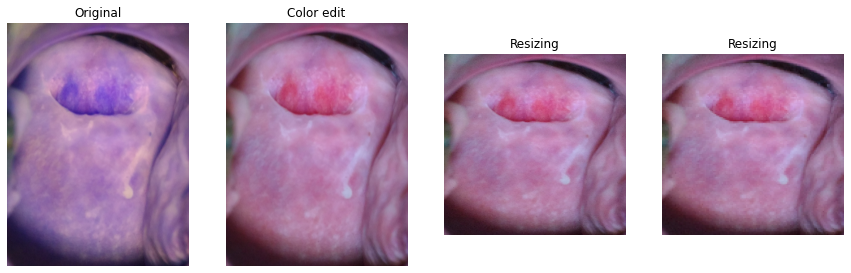

In [ ]:
# load image

fig = plt.figure(figsize= (15,6))
fig.add_subplot(1,4,1)
plt.imshow(cv2.imread(train_df['filepath'].values[0]))
plt.axis(False)
plt.title('Original')

fig.add_subplot(1,4,2)
plt.imshow(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR))
plt.axis(False)
plt.title('Color edit')

fig.add_subplot(1,4,3)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(224,224)))
plt.axis(False)
plt.title('Resizing')

fig.add_subplot(1,4,4)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(128,128)))
plt.axis(False)
plt.title('Resizing')

plt.show()

## Colab 실행

In [4]:
# train data (X normalize)

X_train = np.load('X_train_128.npy')/255
y_train = np.load('y_train_128.npy', allow_pickle=True)

In [5]:
# validation data (X normalize)

X_valid = np.load('X_valid_128.npy', allow_pickle=True)/255
y_valid = np.load('y_valid_128.npy', allow_pickle=True)

In [6]:
# y ONE HOT ENCODING
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

# **모델링**

In [7]:
BATCH_SIZE = 16
EPOCHS = 100

In [8]:
# define training steps
TRAIN_STEPS = 6569//BATCH_SIZE
VAL_STEPS = 1643//BATCH_SIZE

## **CNN (dropout=0.5)**

In [13]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)
train_gen_ag = train_datagen.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

### 1. Non Augmentation

In [9]:
cnn_v2 = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [10]:
# recall trained model

cnn_v2 = keras.models.load_model('cnn_v2.h5')

In [11]:
cnn_v2.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [12]:
history_cnnv2 = np.load('cnn_v2_hist.npy', allow_pickle = 'TRUE').item()

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('cnn_v2.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
#history_cnnv2 = cnn_v2.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint])

Epoch 1/100
410/410 [==============================] - 5s 10ms/step - loss: 1.0088 - accuracy: 0.5170 - val_loss: 0.9698 - val_accuracy: 0.5277

Epoch 00001: val_accuracy improved from -inf to 0.52769, saving model to cnn_v2.weights.hdf5
Epoch 2/100
410/410 [==============================] - 4s 10ms/step - loss: 0.9840 - accuracy: 0.5259 - val_loss: 0.9525 - val_accuracy: 0.5356

Epoch 00002: val_accuracy improved from 0.52769 to 0.53561, saving model to cnn_v2.weights.hdf5
Epoch 3/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9539 - accuracy: 0.5373 - val_loss: 0.9512 - val_accuracy: 0.5417

Epoch 00003: val_accuracy improved from 0.53561 to 0.54169, saving model to cnn_v2.weights.hdf5
Epoch 4/100
410/410 [==============================] - 4s 9ms/step - loss: 0.9414 - accuracy: 0.5385 - val_loss: 0.9403 - val_accuracy: 0.5551

Epoch 00004: val_accuracy improved from 0.54169 to 0.55508, saving model to cnn_v2.weights.hdf5
Epoch 5/100
410/410 [====================

In [ ]:
#cnn_v2.save('cnn_v2.h5')
#np.save('cnn_v2_hist.npy', history_cnnv2.history)

### 2. Augmentation

In [13]:
cnn_v2_ag = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn_v2_ag.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 activation_4 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 activation_5 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [14]:
# recall trained model

cnn_v2_ag = keras.models.load_model('cnn_v2_ag.h5')

In [15]:
cnn_v2_ag.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [16]:
history_cnnv2_ag = np.load('cnn_v2_hist.npy', allow_pickle = 'TRUE').item()

In [25]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint_ag = ModelCheckpoint('cnn_v2_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [26]:
# Non-augmentation
#history_cnnv2_ag = cnn_v2_ag.fit(
#    train_gen_ag
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint_ag])

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 1.0206 - accuracy: 0.5228
Epoch 1: val_accuracy improved from -inf to 0.52952, saving model to cnn_v2_ag.weights.hdf5
410/410 [==============================] - 26s 63ms/step - loss: 1.0206 - accuracy: 0.5228 - val_loss: 0.9994 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 1.0055 - accuracy: 0.5277
Epoch 2: val_accuracy did not improve from 0.52952
410/410 [==============================] - 25s 60ms/step - loss: 1.0055 - accuracy: 0.5277 - val_loss: 0.9810 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 3/100
410/410 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.5285
Epoch 3: val_accuracy did not improve from 0.52952
410/410 [==============================] - 25s 60ms/step - loss: 0.9982 - accuracy: 0.5285 - val_loss: 0.9826 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 4/100
410/410 [==============================] - ETA: 0s - loss: 0.9903

In [27]:
#cnn_v2_ag.save('cnn_v2_ag.h5')
#np.save('cnn_v2_ag_hist.npy', history_cnnv2_ag.history)

### 3. Compare Models

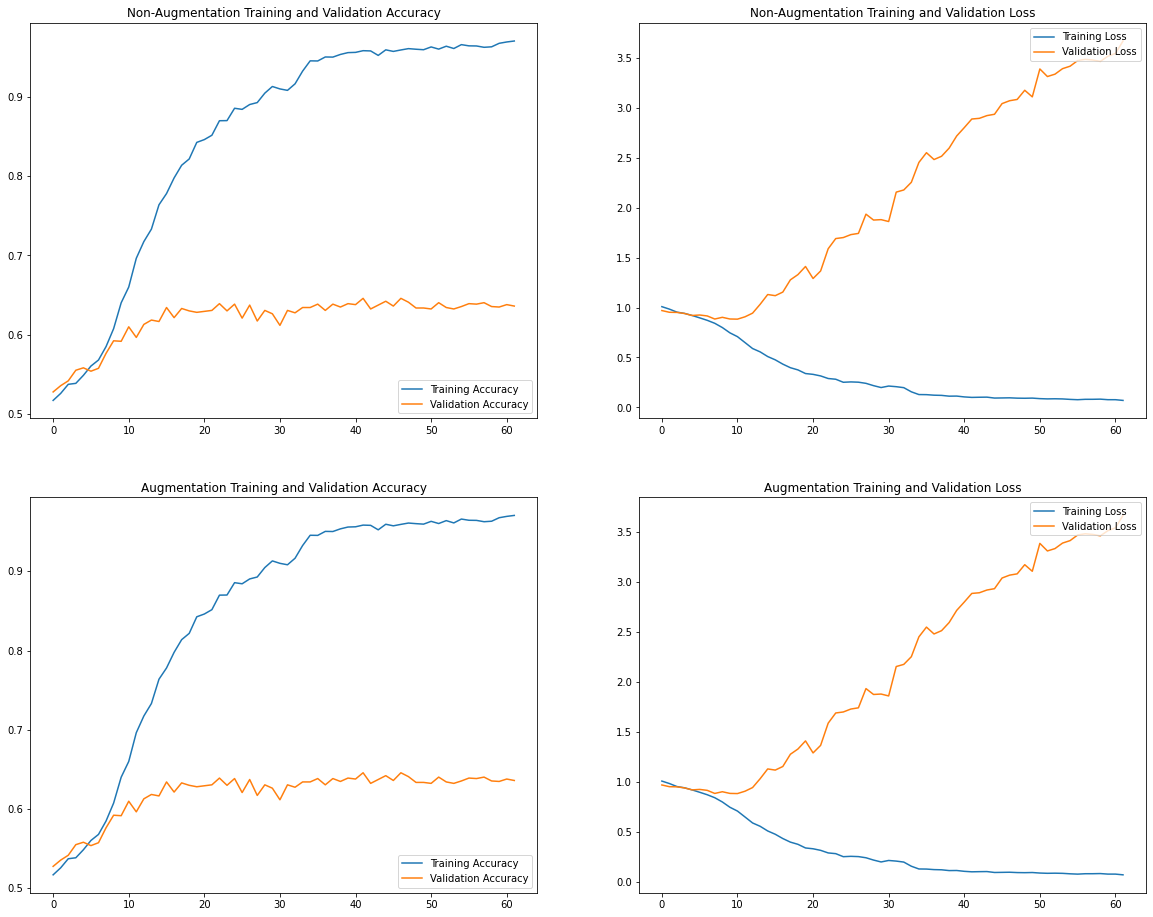

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_cnnv2['accuracy'], label='Training Accuracy')
plt.plot(history_cnnv2['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_cnnv2['loss'], label='Training Loss')
plt.plot(history_cnnv2['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_cnnv2_ag['accuracy'], label='Training Accuracy')
plt.plot(history_cnnv2_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_cnnv2_ag['loss'], label='Training Loss')
plt.plot(history_cnnv2_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **CNN (dropout=0.3)**

In [ ]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)
train_gen_ag = train_datagen.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

### Non Augmentation

In [17]:
cnn_d3 = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
    
])

cnn_d3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 activation_8 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 activation_9 (Activation)   (None, 64, 64, 32)        0         
                                                      

In [19]:
# load model
cnn_d3 = keras.models.load_model('cnn_d3.h5')

In [20]:
cnn_d3.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [21]:
# load history
history_cnn_d3 = np.load('cnn_d3_hist.npy', allow_pickle='TRUE').item()

In [12]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('cnn_d3.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [14]:
#history_cnn_d3 = cnn_d3.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint])

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.5329
Epoch 1: val_accuracy improved from -inf to 0.54413, saving model to cnn_d3.weights.hdf5
410/410 [==============================] - 18s 19ms/step - loss: 1.0086 - accuracy: 0.5329 - val_loss: 1.0099 - val_accuracy: 0.5441 - lr: 0.0010
Epoch 2/100
407/410 [============================>.] - ETA: 0s - loss: 0.9829 - accuracy: 0.5324
Epoch 2: val_accuracy did not improve from 0.54413
410/410 [==============================] - 7s 16ms/step - loss: 0.9834 - accuracy: 0.5314 - val_loss: 0.9675 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 3/100
409/410 [============================>.] - ETA: 0s - loss: 0.9721 - accuracy: 0.5366
Epoch 3: val_accuracy did not improve from 0.54413
410/410 [==============================] - 6s 16ms/step - loss: 0.9720 - accuracy: 0.5369 - val_loss: 0.9507 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 4/100
410/410 [==============================] - ETA: 0s - loss: 0.9492 - ac

In [15]:
#cnn_d3.save('cnn_d3.h5')
#np.save('cnn_d3_hist.npy', history_cnn_d3.history)

### Augmentation

In [22]:
cnn_d3_ag = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
    
])

cnn_d3_ag.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 activation_12 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 activation_13 (Activation)  (None, 64, 64, 32)        0         
                                                      

In [23]:
# load model
cnn_d3_ag = keras.models.load_model('cnn_d3_ag.h5')

In [24]:
cnn_d3_ag.compile(
    'adam'
    , loss='categorical_crossentropy'
    , metrics=['accuracy']
)

In [26]:
# load history
history_cnn_d3_ag = np.load('cnn_d3__aghist.npy',allow_pickle='TRUE').item()

In [18]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint_ag = ModelCheckpoint('cnn_d3_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [19]:
#history_cnn_d3_ag = cnn_d3_ag.fit(
#    train_gen_ag
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint_ag])

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.5257
Epoch 1: val_accuracy improved from -inf to 0.52952, saving model to cnn_d3_ag.weights.hdf5
410/410 [==============================] - 27s 64ms/step - loss: 1.0242 - accuracy: 0.5257 - val_loss: 1.0218 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.5294
Epoch 2: val_accuracy did not improve from 0.52952
410/410 [==============================] - 26s 63ms/step - loss: 1.0044 - accuracy: 0.5294 - val_loss: 0.9917 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 3/100
410/410 [==============================] - ETA: 0s - loss: 0.9968 - accuracy: 0.5291
Epoch 3: val_accuracy did not improve from 0.52952
410/410 [==============================] - 26s 62ms/step - loss: 0.9968 - accuracy: 0.5291 - val_loss: 0.9802 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 4/100
410/410 [==============================] - ETA: 0s - loss: 0.9905

In [20]:
#cnn_d3_ag.save('cnn_d3_ag.h5')
#np.save('cnn_d3_aghist.npy', history_cnn_d3_ag.history)

### Compare Models

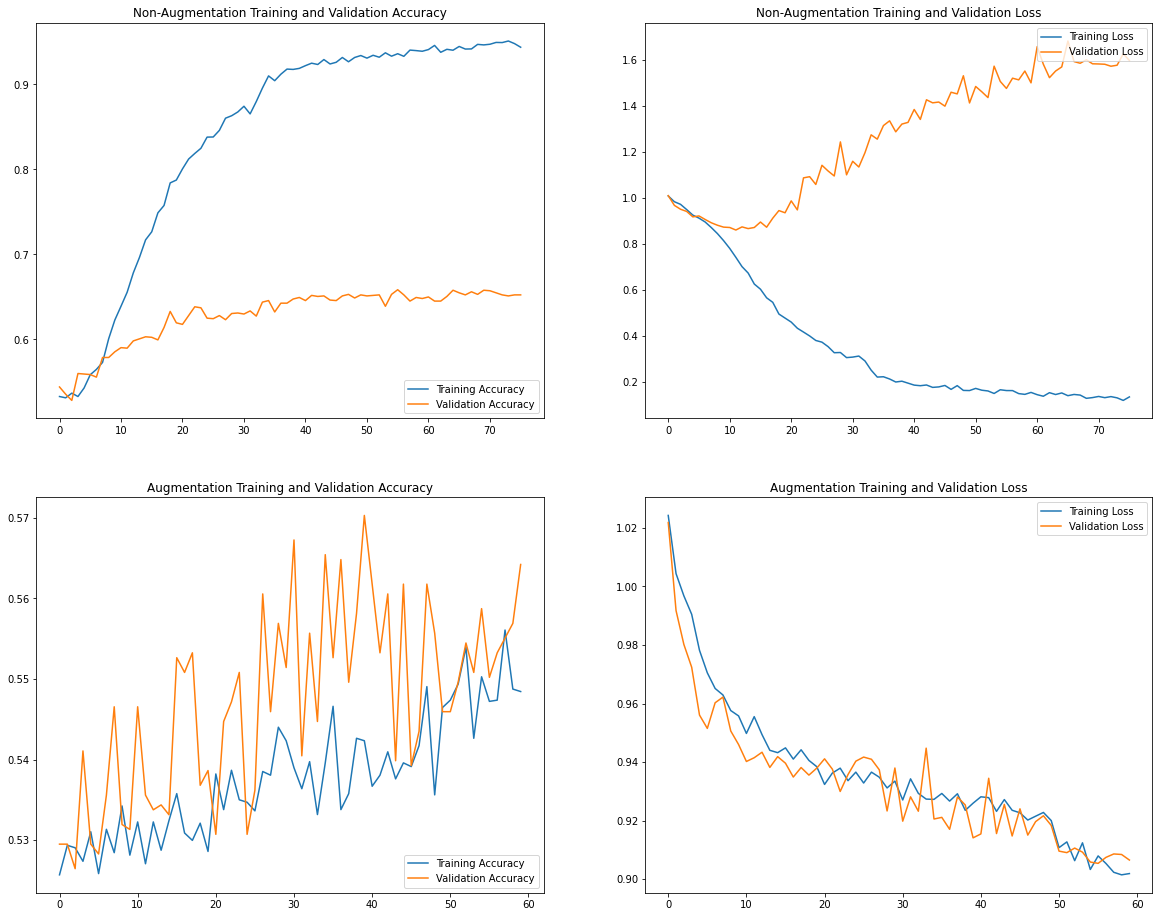

In [21]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_cnn_d3.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_d3.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_cnn_d3.history['loss'], label='Training Loss')
plt.plot(history_cnn_d3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_cnn_d3_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_d3_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_cnn_d3_ag.history['loss'], label='Training Loss')
plt.plot(history_cnn_d3_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **MobileNet V1**

In [33]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

In [27]:
class Depthwise_bn_relu(tf.keras.Model):
    def __init__(self, strides, padding):
        super(Depthwise_bn_relu, self).__init__()

        self.strides = strides
        self.padding = padding

        self.dw = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), 
                                                  strides=self.strides, 
                                                  padding=self.padding,
                                                  use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.dw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x



class Pointwise_bn_relu(tf.keras.Model):
    def __init__(self, nb_filters):
        super(Pointwise_bn_relu, self).__init__()

        self.nb_filters = nb_filters

        self.pw = tf.keras.layers.Conv2D(self.nb_filters,
                                         kernel_size=(1, 1), 
                                         strides=(1, 1),  
                                         padding='same', 
                                         use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.pw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


    


class MobilenetV1(tf.keras.Model):
    def __init__(self, nb_class):
        super(MobilenetV1, self).__init__()

        self.nb_class = nb_class
        self.zero_pad = tf.keras.layers.ZeroPadding2D((2, 2))
        self.conv = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

        self.block1 = tf.keras.Sequential()
        self.block1.add(Depthwise_bn_relu(1, 'same'))
        self.block1.add(Pointwise_bn_relu(64))
        self.zero_pad_1 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
        
        
        self.block2 = tf.keras.Sequential()
        self.block2.add(Depthwise_bn_relu(2, 'valid'))
        self.block2.add(Pointwise_bn_relu(128))
        self.block2.add(Depthwise_bn_relu(1, 'same'))
        self.block2.add(Pointwise_bn_relu(128))
        self.zero_pad_2 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block3 = tf.keras.Sequential()
        self.block3.add(Depthwise_bn_relu(2, 'valid'))
        self.block3.add(Pointwise_bn_relu(256))
        self.block3.add(Depthwise_bn_relu(1, 'same'))
        self.block3.add(Pointwise_bn_relu(256))
        self.zero_pad_3 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block4 = tf.keras.Sequential()
        self.block4.add(Depthwise_bn_relu(2, 'valid'))
        self.block4.add(Pointwise_bn_relu(512))

        for _ in range(5):
            self.block4.add(Depthwise_bn_relu(1, 'same'))
            self.block4.add(Pointwise_bn_relu(512))

        self.zero_pad_4 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))



        self.block5 = tf.keras.Sequential()
        self.block5.add(Depthwise_bn_relu(2, 'valid'))
        self.block5.add(Pointwise_bn_relu(1024))
        self.block5.add(Depthwise_bn_relu(2, 'same'))
        self.block5.add(Pointwise_bn_relu(1024))


        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.reshape = tf.keras.layers.Reshape((1, 1, 1024))
        self.drop = tf.keras.layers.Dropout(0.001)
        self.conv_pred = tf.keras.layers.Conv2D(1000, 
                                                kernel_size=(1, 1), 
                                                strides=(1, 1), 
                                                padding='same', 
                                                activation='softmax')
        self.reshape_2 = tf.keras.layers.Reshape((1000,))

        


    def call(self, x, training=False):
        x = self.zero_pad(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
       
        x = self.block1(x)
        x = self.zero_pad_1(x)

        x = self.block2(x)
        x = self.zero_pad_2(x)

        x = self.block3(x)
        x = self.zero_pad_3(x)

        x = self.block4(x)
        x = self.zero_pad_4(x)

        x = self.block5(x)

        x = self.gap(x)
        x = self.reshape(x)
        x = self.drop(x)
        x = self.conv_pred(x)
        x = self.reshape_2(x)
        
        return x

    

### 1. Non Augmentation Model

In [28]:
mov1 = MobilenetV1(1000)
mov1.build((1, 128, 128, 3))
mov1.summary()

Model: "mobilenet_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          multiple                  864       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 sequential_4 (Sequential)   (1, 65, 65, 64)           2720      
                                                                 
 zero_padding2d_1 (ZeroPaddi  multiple                

In [30]:
# load model
mov1 = keras.models.load_model('mov1')

In [31]:
mov1.compile(
    optimizer = 'adam'
    ,loss = 'sparse_categorical_crossentropy'
    ,metrics = ['accuracy']
)

In [32]:
history_mov1 = np.load('mov1_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('mov1.weights.ckpt', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
# train model
#history_mov1 = mov1.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = 100
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

Epoch 1/100
409/410 [============================>.] - ETA: 0s - loss: 1.1333 - accuracy: 0.4906
Epoch 1: val_accuracy improved from -inf to 0.29519, saving model to mov1.weights.ckpt


410/410 [==============================] - 40s 82ms/step - loss: 1.1333 - accuracy: 0.4902 - val_loss: 1.1626 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 0.9819 - accuracy: 0.5251
Epoch 2: val_accuracy improved from 0.29519 to 0.52769, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 81ms/step - loss: 0.9819 - accuracy: 0.5251 - val_loss: 1.0068 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 3/100
409/410 [============================>.] - ETA: 0s - loss: 0.9690 - accuracy: 0.5253
Epoch 3: val_accuracy improved from 0.52769 to 0.53195, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 81ms/step - loss: 0.9689 - accuracy: 0.5253 - val_loss: 1.0326 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 4/100
410/410 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.5379
Epoch 4: val_accuracy improved from 0.53195 to 0.54291, saving model to mov1.weights.ckpt


410/410 [==============================] - 34s 84ms/step - loss: 0.9458 - accuracy: 0.5379 - val_loss: 0.9513 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 5/100
410/410 [==============================] - ETA: 0s - loss: 0.9334 - accuracy: 0.5365
Epoch 5: val_accuracy did not improve from 0.54291
410/410 [==============================] - 15s 36ms/step - loss: 0.9334 - accuracy: 0.5365 - val_loss: 0.9509 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 6/100
409/410 [============================>.] - ETA: 0s - loss: 0.9170 - accuracy: 0.5492
Epoch 6: val_accuracy improved from 0.54291 to 0.54778, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 80ms/step - loss: 0.9164 - accuracy: 0.5494 - val_loss: 0.9629 - val_accuracy: 0.5478 - lr: 0.0010
Epoch 7/100
409/410 [============================>.] - ETA: 0s - loss: 0.9050 - accuracy: 0.5588
Epoch 7: val_accuracy did not improve from 0.54778
410/410 [==============================] - 15s 37ms/step - loss: 0.9055 - accuracy: 0.5587 - val_loss: 1.1713 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 8/100
409/410 [============================>.] - ETA: 0s - loss: 0.9070 - accuracy: 0.5573
Epoch 8: val_accuracy did not improve from 0.54778
410/410 [==============================] - 15s 37ms/step - loss: 0.9070 - accuracy: 0.5573 - val_loss: 0.9613 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 9/100
409/410 [============================>.] - ETA: 0s - loss: 0.8824 - accuracy: 0.5643
Epoch 9: val_accuracy did not improve from 0.54778
410/410 [==============================] - 15s 37ms/step - loss: 0.8820 - accuracy: 0.5645 - val_loss: 0.9541 - val_ac

410/410 [==============================] - 33s 81ms/step - loss: 0.8475 - accuracy: 0.5935 - val_loss: 0.9701 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 12/100
410/410 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.6051
Epoch 12: val_accuracy improved from 0.55447 to 0.57456, saving model to mov1.weights.ckpt


410/410 [==============================] - 34s 82ms/step - loss: 0.8291 - accuracy: 0.6051 - val_loss: 0.9338 - val_accuracy: 0.5746 - lr: 0.0010
Epoch 13/100
409/410 [============================>.] - ETA: 0s - loss: 0.8002 - accuracy: 0.6274
Epoch 13: val_accuracy did not improve from 0.57456
410/410 [==============================] - 16s 38ms/step - loss: 0.8006 - accuracy: 0.6270 - val_loss: 1.0874 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 14/100
409/410 [============================>.] - ETA: 0s - loss: 0.7770 - accuracy: 0.6431
Epoch 14: val_accuracy did not improve from 0.57456
410/410 [==============================] - 15s 37ms/step - loss: 0.7769 - accuracy: 0.6428 - val_loss: 1.0880 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 15/100
410/410 [==============================] - ETA: 0s - loss: 0.7639 - accuracy: 0.6441
Epoch 15: val_accuracy did not improve from 0.57456
410/410 [==============================] - 15s 37ms/step - loss: 0.7639 - accuracy: 0.6441 - val_loss: 0.9882 - 

410/410 [==============================] - 33s 81ms/step - loss: 0.4748 - accuracy: 0.8051 - val_loss: 1.0312 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 22/100
409/410 [============================>.] - ETA: 0s - loss: 0.4184 - accuracy: 0.8316
Epoch 22: val_accuracy improved from 0.58247 to 0.61108, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 82ms/step - loss: 0.4186 - accuracy: 0.8314 - val_loss: 1.0459 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 23/100
409/410 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8426
Epoch 23: val_accuracy did not improve from 0.61108
410/410 [==============================] - 15s 37ms/step - loss: 0.3866 - accuracy: 0.8422 - val_loss: 1.1495 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 24/100
409/410 [============================>.] - ETA: 0s - loss: 0.3296 - accuracy: 0.8720
Epoch 24: val_accuracy improved from 0.61108 to 0.61716, saving model to mov1.weights.ckpt


410/410 [==============================] - 35s 86ms/step - loss: 0.3298 - accuracy: 0.8718 - val_loss: 1.1661 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 25/100
409/410 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8883
Epoch 25: val_accuracy did not improve from 0.61716
410/410 [==============================] - 15s 37ms/step - loss: 0.2922 - accuracy: 0.8884 - val_loss: 1.2046 - val_accuracy: 0.6159 - lr: 0.0010
Epoch 26/100
409/410 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8949
Epoch 26: val_accuracy improved from 0.61716 to 0.61960, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 81ms/step - loss: 0.2759 - accuracy: 0.8946 - val_loss: 1.2490 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 27/100
409/410 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9073
Epoch 27: val_accuracy did not improve from 0.61960
410/410 [==============================] - 15s 37ms/step - loss: 0.2311 - accuracy: 0.9072 - val_loss: 1.3552 - val_accuracy: 0.6032 - lr: 0.0010
Epoch 28/100
409/410 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.9113
Epoch 28: val_accuracy did not improve from 0.61960
410/410 [==============================] - 15s 37ms/step - loss: 0.2365 - accuracy: 0.9112 - val_loss: 1.4825 - val_accuracy: 0.5886 - lr: 0.0010
Epoch 29/100
410/410 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9263
Epoch 29: val_accuracy improved from 0.61960 to 0.62934, saving model to mov1.weights.ckpt


410/410 [==============================] - 33s 82ms/step - loss: 0.2044 - accuracy: 0.9263 - val_loss: 1.2472 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 30/100
410/410 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9391
Epoch 30: val_accuracy did not improve from 0.62934
410/410 [==============================] - 15s 37ms/step - loss: 0.1661 - accuracy: 0.9391 - val_loss: 1.5354 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 31/100
409/410 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9364
Epoch 31: val_accuracy did not improve from 0.62934
410/410 [==============================] - 15s 37ms/step - loss: 0.1741 - accuracy: 0.9364 - val_loss: 1.4483 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 32/100
409/410 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9457
Epoch 32: val_accuracy did not improve from 0.62934
410/410 [==============================] - 15s 36ms/step - loss: 0.1509 - accuracy: 0.9455 - val_loss: 1.3950 - 

410/410 [==============================] - 33s 80ms/step - loss: 0.0529 - accuracy: 0.9849 - val_loss: 1.5181 - val_accuracy: 0.6537 - lr: 2.0000e-04
Epoch 41/100
409/410 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9953
Epoch 41: val_accuracy did not improve from 0.65368
410/410 [==============================] - 15s 37ms/step - loss: 0.0198 - accuracy: 0.9953 - val_loss: 1.6572 - val_accuracy: 0.6415 - lr: 2.0000e-04
Epoch 42/100
410/410 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9973
Epoch 42: val_accuracy did not improve from 0.65368
410/410 [==============================] - 15s 36ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 1.7368 - val_accuracy: 0.6476 - lr: 2.0000e-04
Epoch 43/100
409/410 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980
Epoch 43: val_accuracy did not improve from 0.65368
410/410 [==============================] - 15s 36ms/step - loss: 0.0089 - accuracy: 0.9980 - val_los

In [ ]:
#mov1.save('mov1', save_format='tf')

In [ ]:
#np.save('mov1_hist.npy', history_mov1.history)

### 2. Augmentation Model

In [33]:
mov1_ag = MobilenetV1(1000)
mov1_ag.build((1,128,128,3))
mov1_ag.summary()

Model: "mobilenet_v1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_5 (ZeroPaddi  multiple                 0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          multiple                  864       
                                                                 
 batch_normalization_27 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             multiple                  0         
                                                                 
 sequential_9 (Sequential)   (1, 65, 65, 64)           2720      
                                                                 
 zero_padding2d_6 (ZeroPaddi  multiple              

In [34]:
# load model
mov1_ag = keras.models.load_model('mov1_ag')

In [35]:
mov1_ag.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [36]:
history_mov1_ag = np.load('mov1_ag_hist.npy', allow_pickle='TRUE').item()

**model saving 제대로 안됨**

In [31]:
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose= 1, mode='max', restore_best_weights= True)

#checkpoint_ag = ModelCheckpoint('mov1_ag.weights.ckpt', monitor = 'val_accuracy', verbose = 1, save_best_only=True, mode= 'max')

In [34]:
#history_mov1_ag = mov1_ag.fit(
#    train_gen_ag
#    , steps_per_epoch= TRAIN_STEPS
#    , validation_data=valid_gen
#    , validation_steps=VAL_STEPS
#    , epochs= 100
#    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
#)

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 1.1384 - accuracy: 0.0368
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to mov1_ag.weights.ckpt


410/410 [==============================] - 47s 110ms/step - loss: 1.1384 - accuracy: 0.0368 - val_loss: 1.0460 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.0150
Epoch 2: val_accuracy did not improve from 0.00000
410/410 [==============================] - 28s 69ms/step - loss: 1.0154 - accuracy: 0.0150 - val_loss: 1.0114 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
410/410 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.0185
Epoch 3: val_accuracy improved from 0.00000 to 0.20527, saving model to mov1_ag.weights.ckpt


410/410 [==============================] - 44s 107ms/step - loss: 1.0034 - accuracy: 0.0185 - val_loss: 1.2174 - val_accuracy: 0.2053 - lr: 0.0010
Epoch 4/100
410/410 [==============================] - ETA: 0s - loss: 0.9836 - accuracy: 0.0314
Epoch 4: val_accuracy did not improve from 0.20527
410/410 [==============================] - 28s 69ms/step - loss: 0.9836 - accuracy: 0.0314 - val_loss: 1.0597 - val_accuracy: 0.0080 - lr: 0.0010
Epoch 5/100
410/410 [==============================] - ETA: 0s - loss: 0.9794 - accuracy: 0.0322
Epoch 5: val_accuracy did not improve from 0.20527
410/410 [==============================] - 29s 70ms/step - loss: 0.9794 - accuracy: 0.0322 - val_loss: 1.0763 - val_accuracy: 0.0735 - lr: 0.0010
Epoch 6/100
410/410 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.0224
Epoch 6: val_accuracy did not improve from 0.20527
410/410 [==============================] - 29s 71ms/step - loss: 0.9752 - accuracy: 0.0224 - val_loss: 1.0028 - val_a

410/410 [==============================] - 44s 108ms/step - loss: 0.9565 - accuracy: 0.0279 - val_loss: 1.0510 - val_accuracy: 0.2102 - lr: 0.0010
Epoch 10/100
410/410 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.0217
Epoch 10: val_accuracy did not improve from 0.21017
410/410 [==============================] - 28s 68ms/step - loss: 0.9589 - accuracy: 0.0217 - val_loss: 0.9887 - val_accuracy: 0.0441 - lr: 0.0010
Epoch 11/100
410/410 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.0304
Epoch 11: val_accuracy did not improve from 0.21017
410/410 [==============================] - 28s 68ms/step - loss: 0.9532 - accuracy: 0.0304 - val_loss: 1.1869 - val_accuracy: 0.1085 - lr: 0.0010
Epoch 12/100
410/410 [==============================] - ETA: 0s - loss: 0.9540 - accuracy: 0.0255
Epoch 12: val_accuracy did not improve from 0.21017
410/410 [==============================] - 28s 68ms/step - loss: 0.9540 - accuracy: 0.0255 - val_loss: 0.9628 -

410/410 [==============================] - 46s 113ms/step - loss: 0.9477 - accuracy: 0.0211 - val_loss: 1.3193 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 14/100
410/410 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.0262
Epoch 14: val_accuracy did not improve from 0.33333
410/410 [==============================] - 28s 69ms/step - loss: 0.9424 - accuracy: 0.0262 - val_loss: 0.9456 - val_accuracy: 0.0239 - lr: 0.0010
Epoch 15/100
410/410 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.0240
Epoch 15: val_accuracy did not improve from 0.33333
410/410 [==============================] - 28s 68ms/step - loss: 0.9428 - accuracy: 0.0240 - val_loss: 0.9427 - val_accuracy: 0.0551 - lr: 0.0010
Epoch 16/100
410/410 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.0183
Epoch 16: val_accuracy did not improve from 0.33333
410/410 [==============================] - 28s 68ms/step - loss: 0.9427 - accuracy: 0.0183 - val_loss: 0.9446 -

410/410 [==============================] - 46s 112ms/step - loss: 0.9357 - accuracy: 0.0172 - val_loss: 1.1948 - val_accuracy: 0.3707 - lr: 0.0010
Epoch 23/100
410/410 [==============================] - ETA: 0s - loss: 0.9267 - accuracy: 0.0290
Epoch 23: val_accuracy did not improve from 0.37071
410/410 [==============================] - 28s 68ms/step - loss: 0.9267 - accuracy: 0.0290 - val_loss: 0.9422 - val_accuracy: 0.0466 - lr: 0.0010
Epoch 24/100
410/410 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.0320
Epoch 24: val_accuracy did not improve from 0.37071
410/410 [==============================] - 28s 68ms/step - loss: 0.9276 - accuracy: 0.0320 - val_loss: 0.9823 - val_accuracy: 0.0864 - lr: 0.0010
Epoch 25/100
410/410 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.0293
Epoch 25: val_accuracy did not improve from 0.37071
410/410 [==============================] - 28s 68ms/step - loss: 0.9306 - accuracy: 0.0293 - val_loss: 1.0018 -

In [35]:
#mov1_ag.save('mov1_ag',save_format='tf')
#np.save('mov1_ag_hist.npy', history_mov1_ag.history)

In [ ]:
#mov1_ag.save_weights('mov1_ag.h5') -> subclassed model의 save 방법 다름, 어떤거 선택할지 의논

### 3. Compare Models

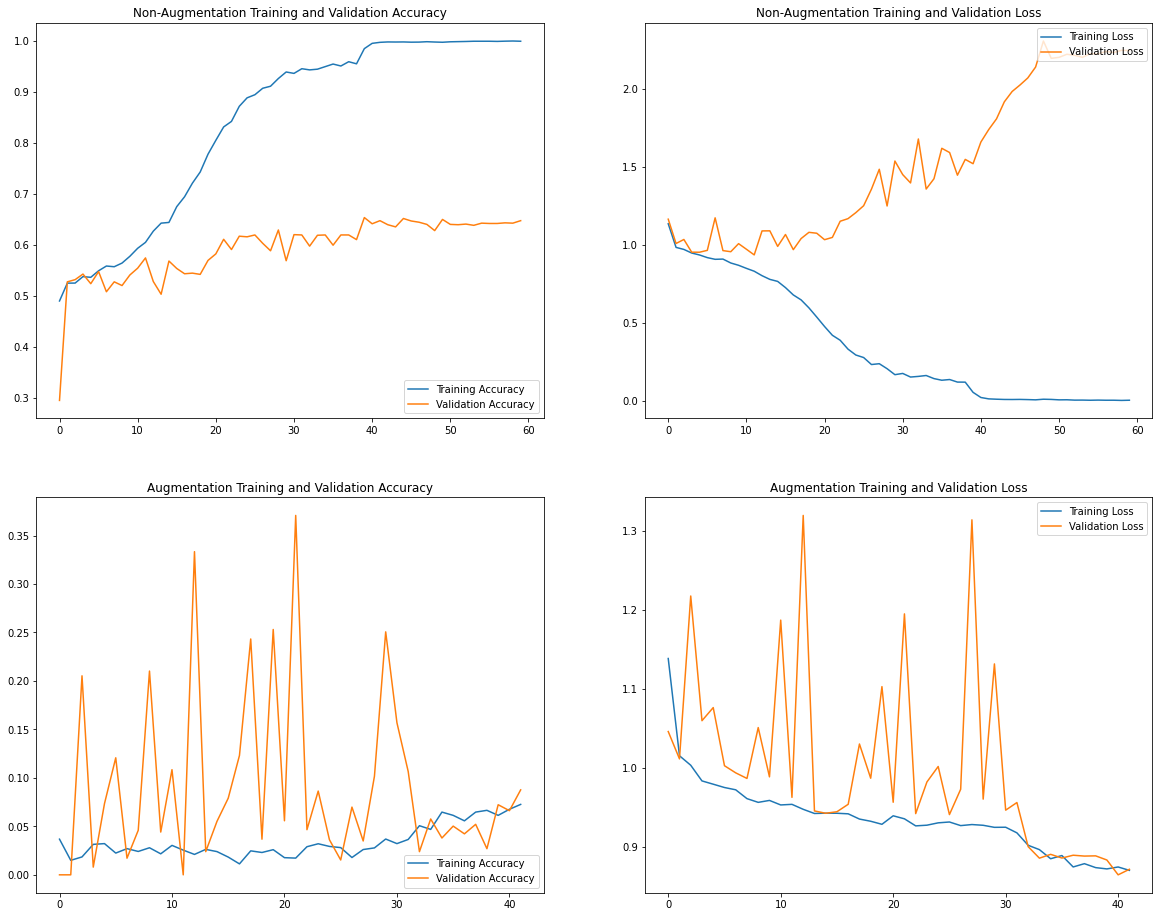

In [37]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_mov1['accuracy'], label='Training Accuracy')
plt.plot(history_mov1['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_mov1['loss'], label='Training Loss')
plt.plot(history_mov1['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_mov1_ag['accuracy'], label='Training Accuracy')
plt.plot(history_mov1_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_mov1_ag['loss'], label='Training Loss')
plt.plot(history_mov1_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **VGG16**

In [ ]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

### 1. Non Augmentation Model

In [38]:
# Build base model (pre-trained)
base = VGG16(input_shape = (128, 128, 3)
                   , weights = 'imagenet'
                   , include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


In [39]:
# show trainable layers before freezing
print('This is the number of trainable weights '
'before freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights before freezing layers in the conv base: 26


In [40]:
# do not train all layers (freezing few layers of pretrained model)
for layer in base.layers[:-3]:
    layer.trainable = False

In [41]:
# show trainable layers after freezing
print('This is the number of trainable weights '
'after freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights after freezing layers in the conv base: 4


In [42]:
vgg16 = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 6,817,795
Non-trainable params: 9,995,072
_________________________________________________________________


In [43]:
# recall trained model

vgg16 = keras.models.load_model('vgg16.h5')

In [44]:
vgg16.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [45]:
history_vgg16 = np.load('vgg16_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# initialize callbacks
#checkpoint = ModelCheckpoint('vgg16.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
# train model

# Non-augmentation
#train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
#valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

#history_vgg16 = vgg16.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = 100
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

Epoch 1/100
410/410 [==============================] - 11s 23ms/step - loss: 0.9868 - accuracy: 0.5222 - val_loss: 0.9099 - val_accuracy: 0.5606

Epoch 00001: val_accuracy improved from -inf to 0.56056, saving model to vgg16.weights.hdf5
Epoch 2/100
410/410 [==============================] - 9s 21ms/step - loss: 0.8843 - accuracy: 0.5778 - val_loss: 0.8574 - val_accuracy: 0.5965

Epoch 00002: val_accuracy improved from 0.56056 to 0.59647, saving model to vgg16.weights.hdf5
Epoch 3/100
410/410 [==============================] - 9s 21ms/step - loss: 0.7908 - accuracy: 0.6283 - val_loss: 0.8324 - val_accuracy: 0.6336

Epoch 00003: val_accuracy improved from 0.59647 to 0.63360, saving model to vgg16.weights.hdf5
Epoch 4/100
410/410 [==============================] - 9s 21ms/step - loss: 0.6729 - accuracy: 0.6956 - val_loss: 0.7887 - val_accuracy: 0.6476

Epoch 00004: val_accuracy improved from 0.63360 to 0.64760, saving model to vgg16.weights.hdf5
Epoch 5/100
410/410 [=====================

In [ ]:
# save model, history (recall -> keras.models.load_model('') -> compile)
#vgg16.save('vgg16.h5')
#np.save('vgg16_hist.npy',history_vgg16.history)

### 2. Augmentation Model

In [46]:
vgg16_ag = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16_ag.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 6,817,795
Non-trainable params: 9,995,072
_________________________________________________________________


In [47]:
# recall trained model

vgg16_ag = keras.models.load_model('vgg16_ag.h5')

In [48]:
vgg16_ag.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [49]:
history_vgg16_ag = np.load('vgg16_ag_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# augmentation

#train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)
#valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint_ag = ModelCheckpoint('vgg16_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
#history_vgg16_ag = vgg16_ag.fit(
#    train_gen_ag
#    , steps_per_epoch= TRAIN_STEPS
#    , validation_data=valid_gen
#    , validation_steps=VAL_STEPS
#    , epochs= 100
#    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
#)

Epoch 1/100
410/410 [==============================] - 30s 72ms/step - loss: 0.9559 - accuracy: 0.5414 - val_loss: 0.8232 - val_accuracy: 0.6244

Epoch 00001: val_accuracy improved from -inf to 0.62439, saving model to vgg_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 27s 66ms/step - loss: 0.9030 - accuracy: 0.5698 - val_loss: 0.8179 - val_accuracy: 0.6262

Epoch 00002: val_accuracy improved from 0.62439 to 0.62623, saving model to vgg_ag.weights.hdf5
Epoch 3/100
410/410 [==============================] - 28s 67ms/step - loss: 0.8821 - accuracy: 0.5704 - val_loss: 0.7908 - val_accuracy: 0.6311

Epoch 00003: val_accuracy improved from 0.62623 to 0.63113, saving model to vgg_ag.weights.hdf5
Epoch 4/100
410/410 [==============================] - 28s 69ms/step - loss: 0.8652 - accuracy: 0.5958 - val_loss: 0.8008 - val_accuracy: 0.6158

Epoch 00004: val_accuracy did not improve from 0.63113
Epoch 5/100
410/410 [==============================] - 29s 70ms/step - loss:

In [ ]:
# save model (recall -> keras.models.load_model('') -> compile)
#vgg16_ag.save('vgg16_ag.h5')
#np.save('vgg16_ag_hist.npy', history_vgg16_ag.history)

### 3. Compare Models

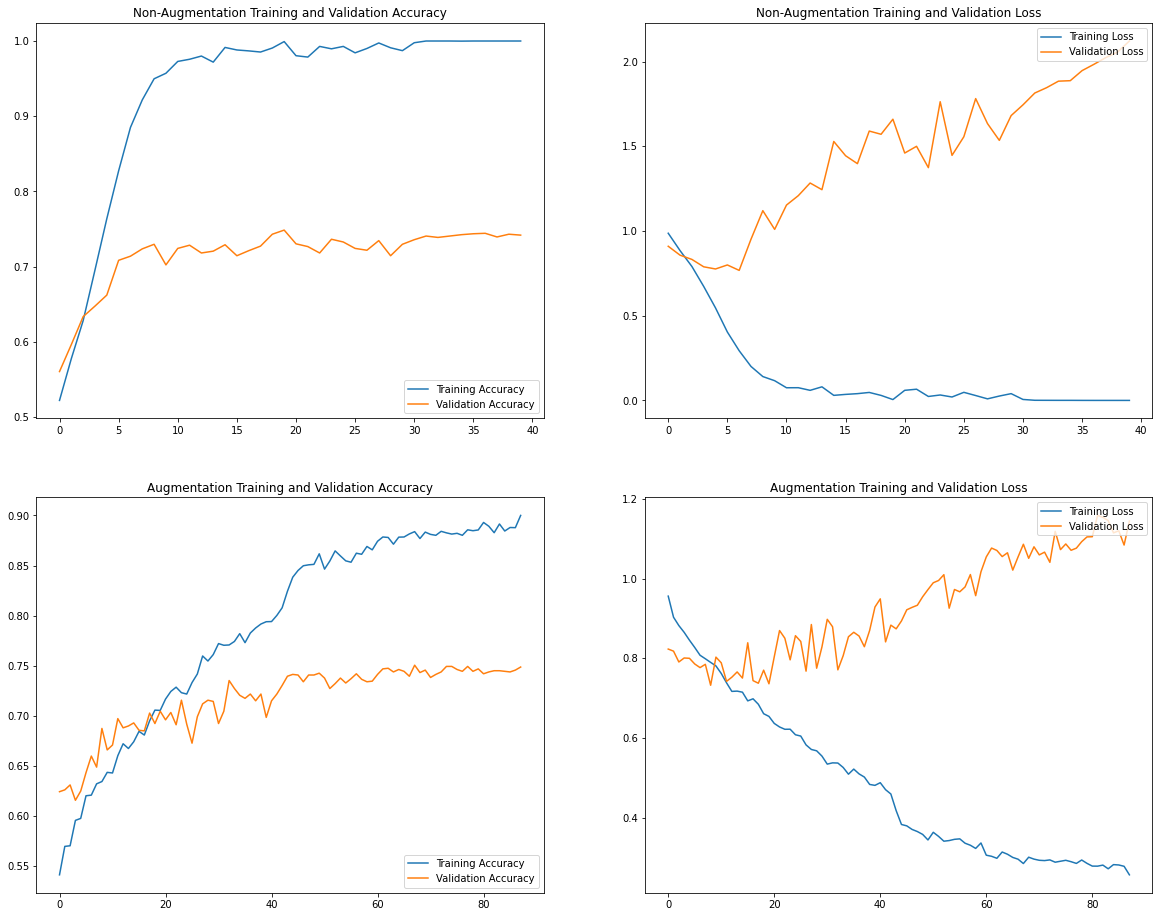

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_vgg16['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_vgg16['loss'], label='Training Loss')
plt.plot(history_vgg16['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_vgg16_ag['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_vgg16_ag['loss'], label='Training Loss')
plt.plot(history_vgg16_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **VGG 19**

In [ ]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)
train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

### 1. Non Augmentation model

In [50]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

vgg19 = keras.Model(inputs=base_model.input, outputs=output)
vgg19.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [51]:
# recall trained model

vgg19 = keras.models.load_model('vgg19.h5')

In [52]:
vgg19.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [53]:
history_vgg19 = np.load('vgg19_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('vgg19.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
#history_vgg19 = vgg19.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data= valid_gen
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

Epoch 1/100
410/410 [==============================] - 11s 23ms/step - loss: 1.0560 - accuracy: 0.4918 - val_loss: 0.9715 - val_accuracy: 0.5423

Epoch 00001: val_accuracy improved from -inf to 0.54230, saving model to vgg19.weights.hdf5
Epoch 2/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9940 - accuracy: 0.5155 - val_loss: 0.9453 - val_accuracy: 0.5356

Epoch 00002: val_accuracy did not improve from 0.54230
Epoch 3/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9695 - accuracy: 0.5295 - val_loss: 0.9439 - val_accuracy: 0.5399

Epoch 00003: val_accuracy did not improve from 0.54230
Epoch 4/100
410/410 [==============================] - 9s 23ms/step - loss: 0.9496 - accuracy: 0.5277 - val_loss: 0.9241 - val_accuracy: 0.5514

Epoch 00004: val_accuracy improved from 0.54230 to 0.55143, saving model to vgg19.weights.hdf5
Epoch 5/100
410/410 [==============================] - 9s 22ms/step - loss: 0.9203 - accuracy: 0.5442 - val_loss: 0.9105 -

In [ ]:
# save model (recall -> keras.models.load_model('') -> compile)
#vgg19.save('vgg19.h5')
#np.save('vgg19_hist.npy', history_vgg19.history)

### 2. Augmentation Model

In [54]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

vgg19_ag = keras.Model(inputs=base_model.input, outputs=output)
vgg19_ag.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [55]:
# recall trained model

vgg19_ag = keras.models.load_model('vgg19_ag.h5')

In [56]:
vgg19_ag.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [57]:
history_vgg19_ag = np.load('vgg19_ag_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint_ag = ModelCheckpoint('vgg19_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
#history_vgg19_ag = vgg19_ag.fit(
#    train_gen_ag
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data= valid_gen
#    , validation_steps = VAL_STEPS
#    , epochs= EPOCHS
#    , verbose=1
#    , callbacks = [reduceLR, early_stopping, checkpoint_ag]
#)

Epoch 1/100
410/410 [==============================] - 29s 70ms/step - loss: 1.0800 - accuracy: 0.4816 - val_loss: 0.9937 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to vgg19_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 28s 68ms/step - loss: 1.0166 - accuracy: 0.5105 - val_loss: 0.9841 - val_accuracy: 0.5300

Epoch 00002: val_accuracy did not improve from 0.53125
Epoch 3/100
410/410 [==============================] - 28s 67ms/step - loss: 1.0099 - accuracy: 0.5172 - val_loss: 0.9785 - val_accuracy: 0.5312

Epoch 00003: val_accuracy did not improve from 0.53125
Epoch 4/100
410/410 [==============================] - 29s 70ms/step - loss: 0.9992 - accuracy: 0.5231 - val_loss: 0.9626 - val_accuracy: 0.5325

Epoch 00004: val_accuracy improved from 0.53125 to 0.53248, saving model to vgg19_ag.weights.hdf5
Epoch 5/100
410/410 [==============================] - 29s 71ms/step - loss: 0.9971 - accuracy: 0.5190 - val_loss

In [ ]:
# save model (recall -> keras.models.load_model('') -> compile)
#vgg19_ag.save('vgg19_ag.h5')
#np.save('vgg19_ag_hist.npy', history_vgg19_ag.history)

### 3. Compare Models

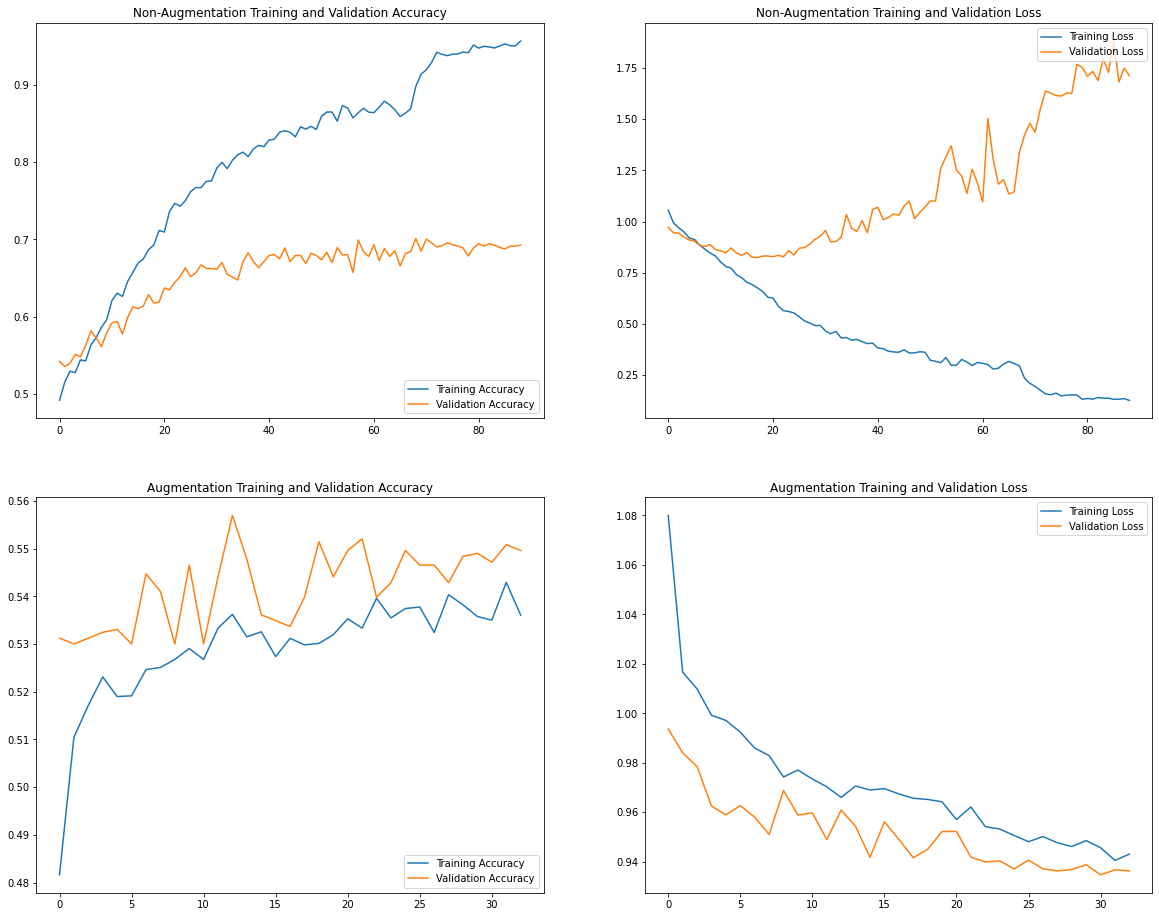

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_vgg19['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_vgg19['loss'], label='Training Loss')
plt.plot(history_vgg19['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_vgg19_ag['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_vgg19_ag['loss'], label='Training Loss')
plt.plot(history_vgg19_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **ResNet18**

In [ ]:
# non-augmentation
train_gen_non = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen = train_datagen.flow(X_train, y_train_onehot, batch_size= BATCH_SIZE)

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('resnet18.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

#checkpoint_ag = ModelCheckpoint('resnet18_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [61]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='SAME')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    return X

def Resnet18(input_shape = (128, 128, 3), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(3, activation = 'softmax')(X) # ouput layer (3class)
    
    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "resnet18")
    
    return model

### 1. Non Augmentation Model

In [62]:
resnet18 = Resnet18()
resnet18.layers[0].trainable = False 
resnet18.summary()

Model: "resnet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_54 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_55 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                         

In [63]:
# recall trained model

resnet18 = keras.models.load_model('resnet18.h5')

In [64]:
resnet18.compile(optimizer='adam'
                 , loss = 'categorical_crossentropy'
                 , metrics=['accuracy'])

In [65]:
history_resnet18 = np.load('resnet18_hist.npy', allow_pickle='TRUE').item()

In [ ]:
#history_resnet18 = resnet18.fit(
#    train_gen_non
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = EPOCHS
#    , batch_size = BATCH_SIZE
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

Epoch 1/100
410/410 [==============================] - 31s 68ms/step - loss: 1.0736 - accuracy: 0.4879 - val_loss: 1.0793 - val_accuracy: 0.4011

Epoch 00001: val_accuracy improved from -inf to 0.40110, saving model to resnet18.weights.hdf5
Epoch 2/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0197 - accuracy: 0.4941 - val_loss: 1.0278 - val_accuracy: 0.4041

Epoch 00002: val_accuracy improved from 0.40110 to 0.40414, saving model to resnet18.weights.hdf5
Epoch 3/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0066 - accuracy: 0.5059 - val_loss: 1.0852 - val_accuracy: 0.5295

Epoch 00003: val_accuracy improved from 0.40414 to 0.52952, saving model to resnet18.weights.hdf5
Epoch 4/100
410/410 [==============================] - 27s 66ms/step - loss: 1.0000 - accuracy: 0.5050 - val_loss: 1.2265 - val_accuracy: 0.5295

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 27s 66ms/step -

In [ ]:
# save model
#resnet18.save('resnet18.h5')
#np.save('resnet18_hist.npy',history_resnet18.history) #history=np.load('my_history.npy',allow_pickle='TRUE').item()

### 2. Augmentation Model

In [66]:
resnet18_ag = Resnet18()
resnet18_ag.layers[0].trainable = False
resnet18_ag.summary()

Model: "resnet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_62 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_74 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_63 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_75 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                         

In [67]:
# recall trained model

resnet18_ag = keras.models.load_model('resnet18_ag.h5')

In [68]:
resnet18_ag.compile(optimizer='adam'
                 , loss = 'categorical_crossentropy'
                 , metrics=['accuracy'])

In [69]:
history_resnet18_ag = np.load('resnet18_ag_hist.npy', allow_pickle='TRUE').item()

In [ ]:
#history_resnet18_ag = resnet18_ag.fit(train_gen, 
#                 steps_per_epoch= TRAIN_STEPS,
#                 validation_data=val_gen, 
#                 epochs=EPOCHS, 
#                 batch_size=BATCH_SIZE, 
#                 callbacks= [reduceLR, early_stopping, checkpoint_ag])

Epoch 1/100
410/410 [==============================] - 41s 95ms/step - loss: 1.0849 - accuracy: 0.4911 - val_loss: 1.1038 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to resnet18_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 34s 83ms/step - loss: 1.0675 - accuracy: 0.4848 - val_loss: 1.2119 - val_accuracy: 0.3530

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 35s 84ms/step - loss: 1.0382 - accuracy: 0.4900 - val_loss: 1.1266 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/100
410/410 [==============================] - 34s 83ms/step - loss: 1.0314 - accuracy: 0.4920 - val_loss: 1.1399 - val_accuracy: 0.2775

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 34s 84ms/step - loss: 1.0231 - accuracy: 0.5002 - val_loss: 1.7019 - val_accuracy: 0.1753

Epoch 0

In [ ]:
# save model
#resnet18_ag.save('resnet18_ag.h5')
#np.save('resnet18_ag_hist.npy', history_resnet18_ag.history)

### 3. Compare Models

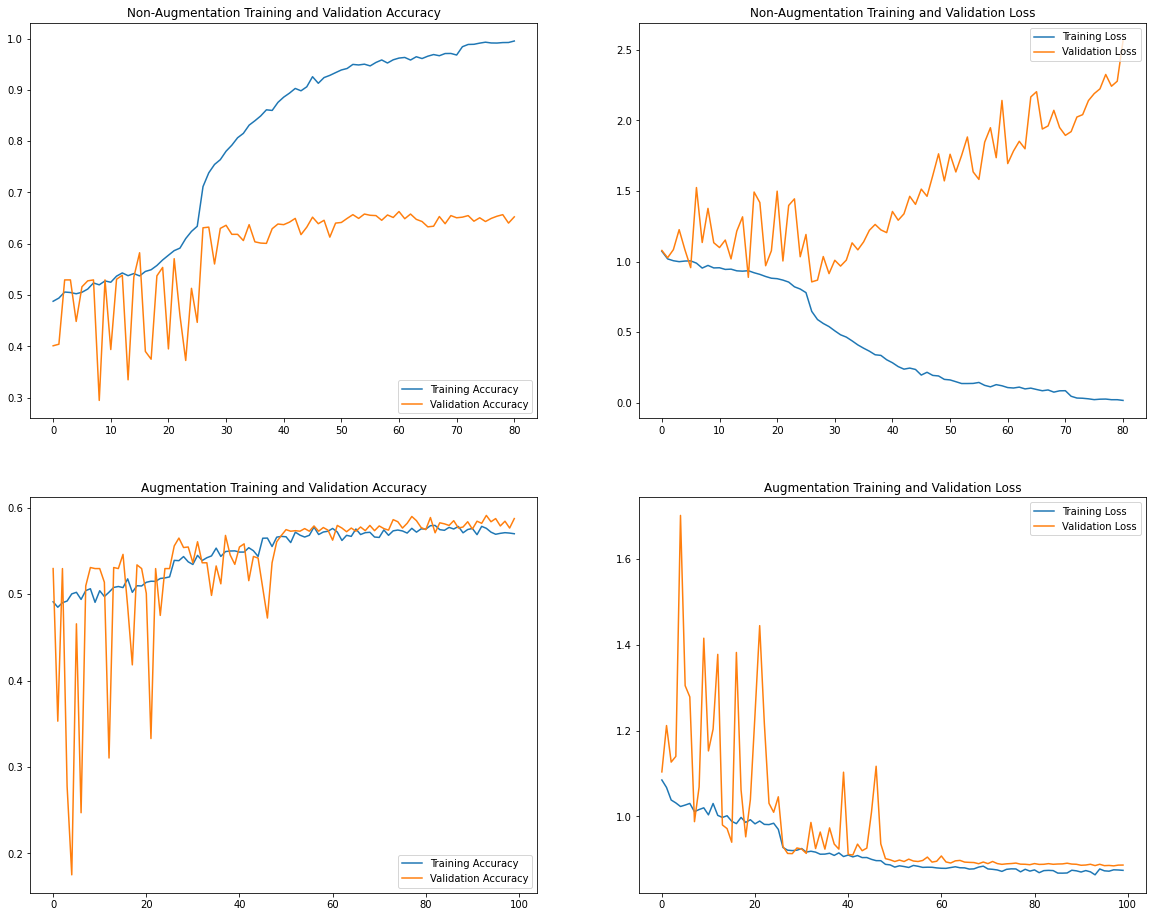

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_resnet18['accuracy'], label='Training Accuracy')
plt.plot(history_resnet18['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet18['loss'], label='Training Loss')
plt.plot(history_resnet18['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_resnet18_ag['accuracy'], label='Training Accuracy')
plt.plot(history_resnet18_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_resnet18_ag['loss'], label='Training Loss')
plt.plot(history_resnet18_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## **Resnet50 (pre-trained)**

In [ ]:
# data

# Non augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

### 1. Non Augmentation

In [70]:
resnet50 = Sequential([
    ResNet50(input_shape = (128,128,3) ,include_top = False, pooling = 'avg')
    , Flatten()
    , BatchNormalization()
    , Dense(512, activation = 'relu')
    , BatchNormalization()
    , Dense(256, activation = 'relu')
    , BatchNormalization()
    , Dense(3, activation = 'softmax')
])
resnet50.layers[0].trainable = False

resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_95 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                      

In [71]:
# recall models

resnet50 = keras.models.load_model('resnet50.h5')

In [72]:
resnet50.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [73]:
history_resnet50 = np.load('resnet50_hist.npy', allow_pickle ='TRUE').item()

In [ ]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose= 1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('resnet50.weights.hdf5', monitor='val_accuracy', verbose= 1,save_best_only=True, mode= 'max')

In [ ]:
# Non-augmentation
#history_resnet50 = resnet50.fit(
#    train_gen
#   , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = 100
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

Epoch 1/100
410/410 [==============================] - 15s 29ms/step - loss: 1.1053 - accuracy: 0.4902 - val_loss: 1.0412 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to resnet50.weights.hdf5
Epoch 2/100
410/410 [==============================] - 11s 27ms/step - loss: 0.9788 - accuracy: 0.5199 - val_loss: 0.9940 - val_accuracy: 0.5295

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 10s 26ms/step - loss: 0.9495 - accuracy: 0.5477 - val_loss: 1.0532 - val_accuracy: 0.5301

Epoch 00003: val_accuracy improved from 0.52952 to 0.53013, saving model to resnet50.weights.hdf5
Epoch 4/100
410/410 [==============================] - 11s 26ms/step - loss: 0.9330 - accuracy: 0.5555 - val_loss: 0.9926 - val_accuracy: 0.5362

Epoch 00004: val_accuracy improved from 0.53013 to 0.53621, saving model to resnet50.weights.hdf5
Epoch 5/100
410/410 [==============================] - 11s 26ms/step -

In [ ]:
# save model (recall -> keras.models.load_model('') -> compile)
#resnet50.save('resnet50.h5')
#np.save('resnet50_hist.npy',history_resnet50.history)

### 2. Augmentation Model

In [74]:
resnet50_ag = Sequential([
    ResNet50(input_shape = (128,128,3) ,include_top = False, pooling = 'avg')
    , Flatten()
    , BatchNormalization()
    , Dense(512, activation = 'relu')
    , BatchNormalization()
    , Dense(256, activation = 'relu')
    , BatchNormalization()
    , Dense(3, activation = 'softmax')
])
resnet50_ag.layers[0].trainable = False

resnet50_ag.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_97 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_98 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 256)             

In [75]:
# recall trained model

resnet50_ag = keras.models.load_model('resnet50_ag.h5')

In [76]:
resnet50_ag.compile(
    optimizer = 'adam'
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [77]:
history_resnet50_ag = np.load('resnet50_ag_hist.npy', allow_pickle='TRUE').item()

In [ ]:
# initialize callbacks
#checkpoint_ag = ModelCheckpoint('resnet50_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
# augmentation
#history_resnet50_ag = resnet50_ag.fit(
#    train_gen_ag
#    , steps_per_epoch= TRAIN_STEPS
#    , validation_data=valid_gen
#    , validation_steps=VAL_STEPS
#    , epochs= 100
#    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
#)

Epoch 1/100
410/410 [==============================] - 37s 83ms/step - loss: 1.1606 - accuracy: 0.4624 - val_loss: 1.0105 - val_accuracy: 0.5300

Epoch 00001: val_accuracy improved from -inf to 0.53002, saving model to resnet50_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 30s 73ms/step - loss: 1.0317 - accuracy: 0.5042 - val_loss: 1.0297 - val_accuracy: 0.4988

Epoch 00002: val_accuracy did not improve from 0.53002
Epoch 3/100
410/410 [==============================] - 30s 72ms/step - loss: 1.0206 - accuracy: 0.5100 - val_loss: 1.0142 - val_accuracy: 0.5263

Epoch 00003: val_accuracy did not improve from 0.53002
Epoch 4/100
410/410 [==============================] - 31s 75ms/step - loss: 1.0129 - accuracy: 0.5108 - val_loss: 1.0592 - val_accuracy: 0.4963

Epoch 00004: val_accuracy did not improve from 0.53002
Epoch 5/100
410/410 [==============================] - 30s 72ms/step - loss: 1.0139 - accuracy: 0.5134 - val_loss: 1.0563 - val_accuracy: 0.5098

Epoch 0

In [ ]:
# save model (recall -> keras.models.load_model('') -> compile)
#resnet50_ag.save('resnet50_ag.h5')
#np.save('resnet50_ag_hist',history_resnet50_ag.history)

### 3. Compare Models

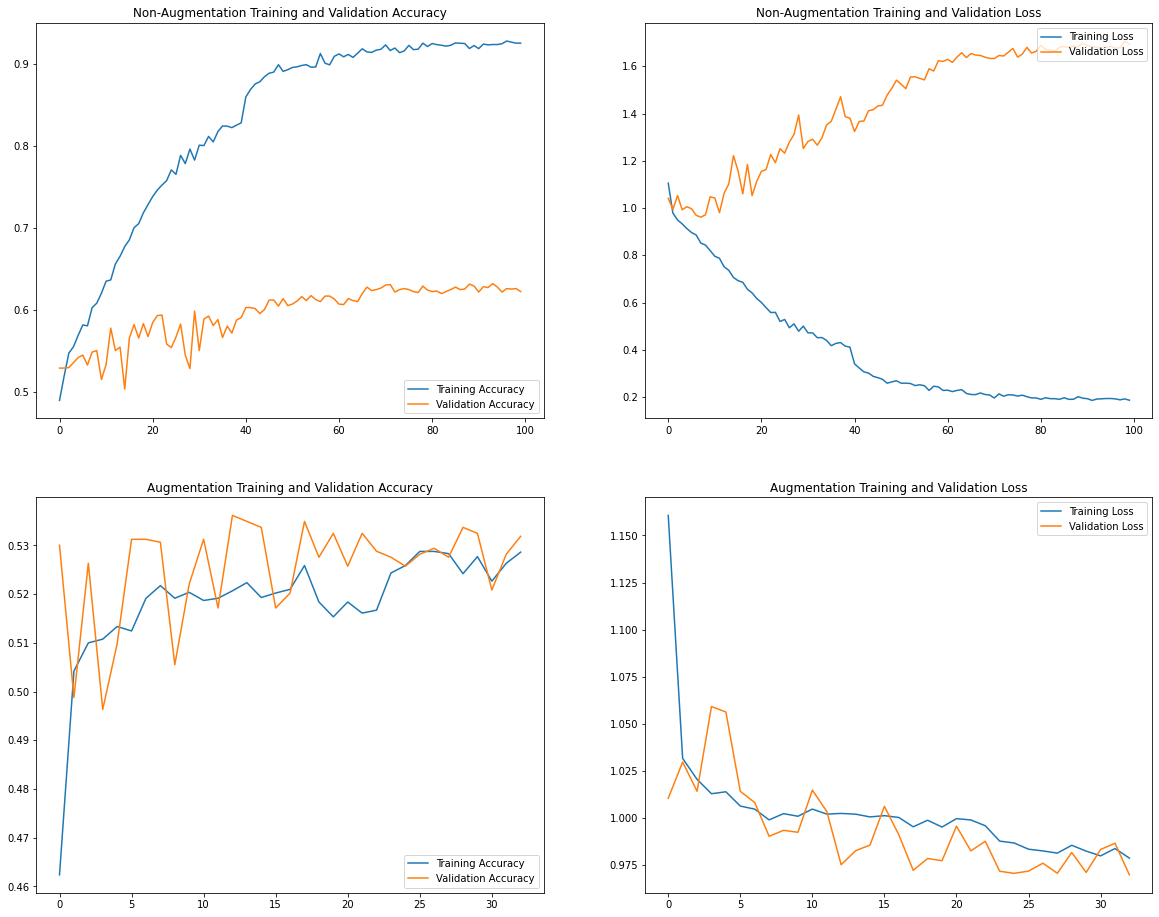

In [ ]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_resnet50['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet50['loss'], label='Training Loss')
plt.plot(history_resnet50['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_resnet50_ag['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50_ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_resnet50_ag['loss'], label='Training Loss')
plt.plot(history_resnet50_ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

# **모델진단**

## **test data**

In [ ]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in tqdm(test_y[['image_name']].to_numpy()):
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        img = cv2.imread(filepath)
#        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#        resized_img = cv2.resize(img, (128, 128))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#X_test = np.array(test_features)
#y_test = np.array(test_type)

In [ ]:
# save test data as npy files

#np.save('/kaggle/working/X_test_128', X_test)
#np.save('/kaggle/working/y_test_128', y_test)

In [78]:
# load data

X_test = np.load('X_test_128.npy')/255
y_test_onehot = np.load('y_test_128.npy', allow_pickle=True)

In [79]:
ydf = pd.DataFrame(y_test_onehot)

In [80]:
ydf[0] = ydf[0].replace(1, 't1')
ydf[1] = ydf[1].replace(1, 't2')
ydf[2] = ydf[2].replace(1, 't3')

In [81]:
type1 = ydf[ydf[0].isin(['t1'])][0]
type2 = ydf[ydf[1].isin(['t2'])][1]
type3 = ydf[ydf[2].isin(['t3'])][2]

In [82]:
type = pd.concat([type1, type2, type3])
type

2      t1
16     t1
20     t1
23     t1
25     t1
       ..
496    t3
499    t3
502    t3
504    t3
511    t3
Length: 512, dtype: object

In [83]:
type = type.replace('t1',0)
type = type.replace('t2',1)
type = type.replace('t3',2)

In [84]:
type = type.sort_index()
y_test = np.array(type)

In [86]:
test_gen = ImageDataGenerator().flow(X_test, y_test, batch_size = BATCH_SIZE)

In [87]:
y_test_onehot = np.asarray(y_test_onehot).astype(np.float32) 
test_gen_onehot = ImageDataGenerator().flow(X_test, y_test_onehot, batch_size = BATCH_SIZE)

## **Accuracy Graph About Validation Dataset**

**전체 모델**

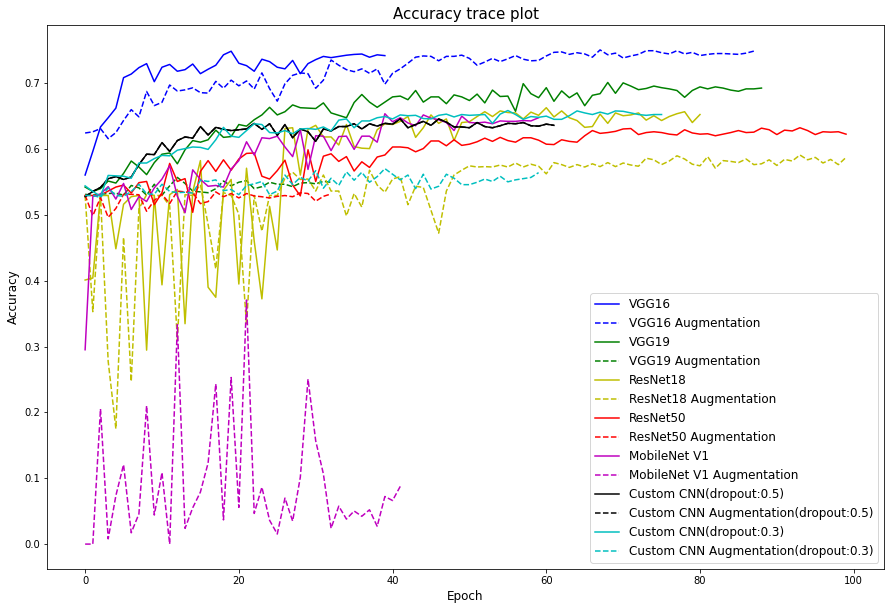

In [127]:
plt.figure(figsize=(15,10))

plt.plot(history_vgg16['val_accuracy'], 'b-', label='VGG16')
plt.plot(history_vgg16_ag['val_accuracy'], 'b--', label='VGG16 Augmentation')

plt.plot(history_vgg19['val_accuracy'], 'g-', label='VGG19')
plt.plot(history_vgg19_ag['val_accuracy'], 'g--', label='VGG19 Augmentation')

plt.plot(history_resnet18['val_accuracy'], 'y-', label='ResNet18')
plt.plot(history_resnet18_ag['val_accuracy'], 'y--', label='ResNet18 Augmentation')

plt.plot(history_resnet50['val_accuracy'], 'r-', label='ResNet50')
plt.plot(history_resnet50_ag['val_accuracy'], 'r--', label='ResNet50 Augmentation')

plt.plot(history_mov1['val_accuracy'], 'm-', label='MobileNet V1')
plt.plot(history_mov1_ag['val_accuracy'], 'm--', label='MobileNet V1 Augmentation')

plt.plot(history_cnnv2['val_accuracy'], 'k-', label='Custom CNN(dropout:0.5)')
plt.plot(history_cnnv2_ag['val_accuracy'], 'k--', label='Custom CNN Augmentation(dropout:0.5)')

plt.plot(history_cnn_d3['val_accuracy'], 'c-', label='Custom CNN(dropout:0.3)')
plt.plot(history_cnn_d3_ag['val_accuracy'],'c--', label='Custom CNN Augmentation(dropout:0.3)')


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

**Non Augmentation 모델**

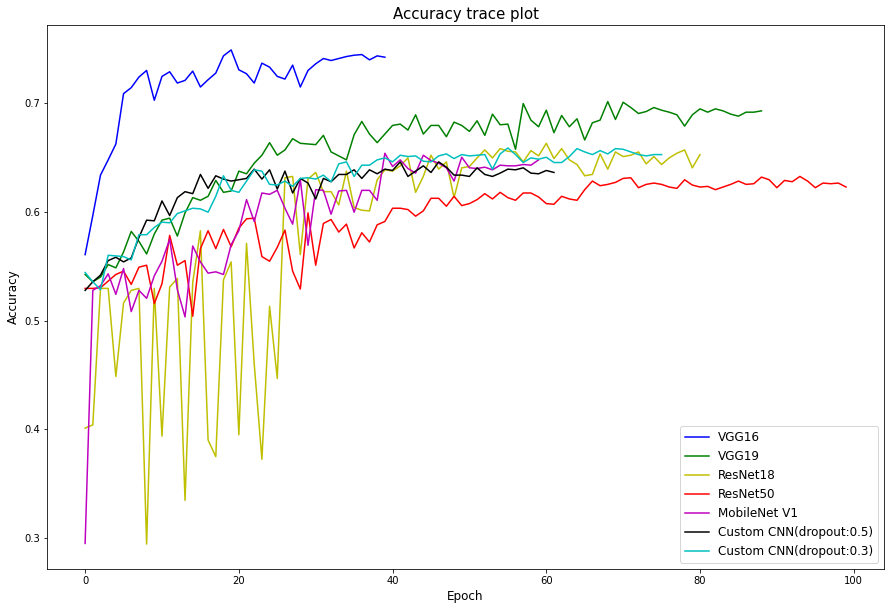

In [128]:
plt.figure(figsize=(15,10))

plt.plot(history_vgg16['val_accuracy'], 'b-', label='VGG16')


plt.plot(history_vgg19['val_accuracy'], 'g-', label='VGG19')


plt.plot(history_resnet18['val_accuracy'], 'y-', label='ResNet18')


plt.plot(history_resnet50['val_accuracy'], 'r-', label='ResNet50')


plt.plot(history_mov1['val_accuracy'], 'm-', label='MobileNet V1')


plt.plot(history_cnnv2['val_accuracy'], 'k-', label='Custom CNN(dropout:0.5)')


plt.plot(history_cnn_d3['val_accuracy'], 'c-', label='Custom CNN(dropout:0.3)')


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

**Augmentation 모델**

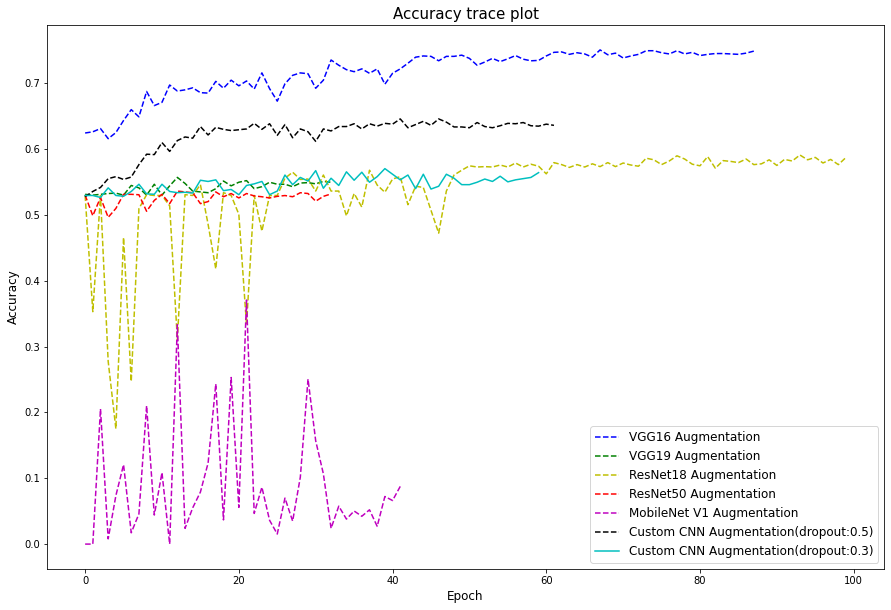

In [130]:
plt.figure(figsize=(15,10))


plt.plot(history_vgg16_ag['val_accuracy'], 'b--', label='VGG16 Augmentation')


plt.plot(history_vgg19_ag['val_accuracy'], 'g--', label='VGG19 Augmentation')


plt.plot(history_resnet18_ag['val_accuracy'], 'y--', label='ResNet18 Augmentation')


plt.plot(history_resnet50_ag['val_accuracy'], 'r--', label='ResNet50 Augmentation')


plt.plot(history_mov1_ag['val_accuracy'], 'm--', label='MobileNet V1 Augmentation')


plt.plot(history_cnnv2_ag['val_accuracy'], 'k--', label='Custom CNN Augmentation(dropout:0.5)')


plt.plot(history_cnn_d3_ag['val_accuracy'], 'c-', label='Custom CNN Augmentation(dropout:0.3)')


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.title('Accuracy trace plot', fontsize=15)
plt.show()

## Confusion Matrix

### **CNN(dropout=0.5)**

#### Non Augmentation

In [88]:
cnn_v2.evaluate(test_gen_onehot)

32/32 [==============================] - 4s 94ms/step - loss: 3.6971 - accuracy: 0.6074


[3.6970624923706055, 0.607421875]

In [89]:
y_pred_enc = cnn_v2.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 3s 191ms/step


,Type 1,Type 2,Type 3
Type 1,41,35,11
Type 2,22,192,51
Type 3,4,78,78


In [90]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.47      0.53        87
           1       0.63      0.72      0.67       265
           2       0.56      0.49      0.52       160

    accuracy                           0.61       512
   macro avg       0.60      0.56      0.58       512
weighted avg       0.60      0.61      0.60       512



In [92]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.607421875
0.607421875


#### Augmentation

In [94]:
cnn_v2_ag.evaluate(test_gen_onehot)

32/32 [==============================] - 4s 113ms/step - loss: 0.8693 - accuracy: 0.5801


[0.8692640662193298, 0.580078125]

In [95]:
y_pred_enc = cnn_v2_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 3s 185ms/step


,Type 1,Type 2,Type 3
Type 1,9,74,4
Type 2,2,235,28
Type 3,0,107,53


In [96]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.10      0.18        87
           1       0.56      0.89      0.69       265
           2       0.62      0.33      0.43       160

    accuracy                           0.58       512
   macro avg       0.67      0.44      0.44       512
weighted avg       0.63      0.58      0.52       512



In [97]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.580078125
0.580078125


### **CNN(dropout=0.3)**

#### Non Augmentation

In [99]:
cnn_d3.evaluate(test_gen_onehot)

32/32 [==============================] - 4s 110ms/step - loss: 1.7984 - accuracy: 0.5918


[1.7983689308166504, 0.591796875]

In [100]:
y_pred_enc = cnn_d3.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 3s 169ms/step


,Type 1,Type 2,Type 3
Type 1,38,39,10
Type 2,34,193,38
Type 3,7,81,72


In [103]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.44      0.46        87
           1       0.62      0.73      0.67       265
           2       0.60      0.45      0.51       160

    accuracy                           0.59       512
   macro avg       0.57      0.54      0.55       512
weighted avg       0.59      0.59      0.58       512



In [104]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.591796875
0.591796875


#### Augmentation

In [113]:
cnn_d3_ag.evaluate(test_gen_onehot)

32/32 [==============================] - 5s 128ms/step - loss: 0.8786 - accuracy: 0.5918


[0.8786242604255676, 0.591796875]

In [117]:
y_pred_enc = cnn_d3_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 4s 250ms/step


,Type 1,Type 2,Type 3
Type 1,15,69,3
Type 2,4,242,19
Type 3,0,114,46


In [118]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.17      0.28        87
           1       0.57      0.91      0.70       265
           2       0.68      0.29      0.40       160

    accuracy                           0.59       512
   macro avg       0.68      0.46      0.46       512
weighted avg       0.64      0.59      0.54       512



In [119]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.591796875
0.591796875


### **MobileNet V1**

#### Non Augmentation

In [ ]:
mov1.load_weights('mov1.weights.ckpt')

In [105]:
# 정밀도
mov1.evaluate(test_gen)

32/32 [==============================] - 6s 175ms/step - loss: 1.6359 - accuracy: 0.5996


[1.63590669631958, 0.599609375]

In [106]:
y_pred_enc = mov1.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 4s 241ms/step


,Type 1,Type 2,Type 3
Type 1,44,39,4
Type 2,24,191,50
Type 3,6,82,72


In [107]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.59      0.51      0.55        87
           1       0.61      0.72      0.66       265
           2       0.57      0.45      0.50       160

    accuracy                           0.60       512
   macro avg       0.59      0.56      0.57       512
weighted avg       0.60      0.60      0.59       512



In [108]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.599609375
0.599609375


#### Augmentation

In [ ]:
mov1_ag.load_weights('mov1_ag.h5')

In [109]:
# 정밀도
mov1_ag.evaluate(test_gen)

32/32 [==============================] - 4s 125ms/step - loss: 1.0123 - accuracy: 0.4277


[1.012270450592041, 0.427734375]

In [110]:
y_pred_enc = mov1_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 4s 238ms/step


,Type 1,Type 2,Type 3
Type 1,50,37,0
Type 2,98,167,0
Type 3,15,143,2


In [111]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.31      0.57      0.40        87
           1       0.48      0.63      0.55       265
           2       1.00      0.01      0.02       160

    accuracy                           0.43       512
   macro avg       0.60      0.41      0.32       512
weighted avg       0.61      0.43      0.36       512



In [112]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 정밀도
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.427734375
0.427734375


### **VGG16**

#### Non Augmentation

In [ ]:
#load best weights
vgg16.load_weights('vgg16.weights.hdf5')

In [ ]:
# 정밀도
vgg16.evaluate(test_gen)

32/32 [==============================] - 10s 30ms/step - loss: 2.3206 - accuracy: 0.6641


[2.3206443786621094, 0.6640625]

In [ ]:
y_pred_enc = vgg16.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 2s 46ms/step


,Type 1,Type 2,Type 3
Type 1,45,34,8
Type 2,15,206,44
Type 3,4,67,89


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.52      0.60        87
           1       0.67      0.78      0.72       265
           2       0.63      0.56      0.59       160

    accuracy                           0.66       512
   macro avg       0.67      0.62      0.64       512
weighted avg       0.66      0.66      0.66       512



In [ ]:
## 특이도
print(sklearn.metrics.recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도(재현율)
print(sklearn.metrics.recall_score(y_test, y_pred, average = 'micro'))

0.6640625
0.6640625
0.6640625


#### Augmentation

In [ ]:
vgg16_ag.load_weights('vgg16_ag.weights.hdf5')

In [ ]:
# 정밀도
vgg16_ag.evaluate(test_gen)

32/32 [==============================] - 83s 3s/step - loss: 1.3822 - accuracy: 0.6855


[1.3822267055511475, 0.685546875]

In [ ]:
y_pred_enc = vgg16_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
       
df

16/16 [==============================] - 79s 5s/step


,Type 1,Type 2,Type 3
Type 1,51,26,10
Type 2,18,205,42
Type 3,6,59,95


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        87
           1       0.71      0.77      0.74       265
           2       0.65      0.59      0.62       160

    accuracy                           0.69       512
   macro avg       0.68      0.65      0.66       512
weighted avg       0.68      0.69      0.68       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.685546875
0.685546875
0.685546875


### VGG19

#### Non Augmentation

In [ ]:
vgg19.load_weights('vgg19.weights.hdf5')

In [ ]:
# 정밀도
vgg19.evaluate(test_gen)

32/32 [==============================] - 1s 40ms/step - loss: 1.7516 - accuracy: 0.6465


[1.751577615737915, 0.646484375]

In [ ]:
y_pred_enc = vgg19.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 1s 62ms/step


,Type 1,Type 2,Type 3
Type 1,32,40,15
Type 2,9,218,38
Type 3,0,79,81


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.37      0.50        87
           1       0.65      0.82      0.72       265
           2       0.60      0.51      0.55       160

    accuracy                           0.65       512
   macro avg       0.68      0.57      0.59       512
weighted avg       0.66      0.65      0.63       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.646484375
0.646484375


#### Augmentation

In [ ]:
vgg19_ag.load_weights('vgg19_ag.weights.hdf5')

#정분류율
vgg19_ag.evaluate(test_gen)

32/32 [==============================] - 1s 36ms/step - loss: 0.9585 - accuracy: 0.5312


[0.9584615230560303, 0.53125]

In [ ]:
y_pred_enc = vgg19_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 1s 61ms/step


,Type 1,Type 2,Type 3
Type 1,0,84,3
Type 2,0,246,19
Type 3,0,134,26


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.53      0.93      0.67       265
           2       0.54      0.16      0.25       160

    accuracy                           0.53       512
   macro avg       0.36      0.36      0.31       512
weighted avg       0.44      0.53      0.43       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.53125
0.53125


### **ResNet18**

#### Non Augmentation

In [ ]:
resnet18.load_weights('resnet18.weights.hdf5')

#정분류율
resnet18.evaluate(test_gen_onehot)

32/32 [==============================] - 2s 38ms/step - loss: 2.1254 - accuracy: 0.5742


[2.125438928604126, 0.57421875]

In [ ]:
y_pred_enc = resnet18.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 2s 52ms/step


,Type 1,Type 2,Type 3
Type 1,40,34,13
Type 2,51,165,49
Type 3,4,67,89


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.42      0.46      0.44        87
           1       0.62      0.62      0.62       265
           2       0.59      0.56      0.57       160

    accuracy                           0.57       512
   macro avg       0.54      0.55      0.54       512
weighted avg       0.58      0.57      0.58       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.57421875
0.57421875


#### Augmentation

In [ ]:
resnet18_ag.load_weights('resnet18_ag.weights.hdf5')

#정분류율
resnet18_ag.evaluate(test_gen_onehot)

32/32 [==============================] - 2s 38ms/step - loss: 0.7926 - accuracy: 0.6543


[0.7925646305084229, 0.654296875]

In [ ]:
y_pred_enc = resnet18_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 1s 61ms/step


,Type 1,Type 2,Type 3
Type 1,20,64,3
Type 2,15,216,34
Type 3,0,61,99


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.23      0.33        87
           1       0.63      0.82      0.71       265
           2       0.73      0.62      0.67       160

    accuracy                           0.65       512
   macro avg       0.64      0.55      0.57       512
weighted avg       0.65      0.65      0.63       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.654296875
0.654296875


### **ResNet50**

#### Non Augmentation

In [ ]:
resnet50.load_weights('resnet50.weights.hdf5')

#정분류율
resnet50.evaluate(test_gen)

32/32 [==============================] - 3s 34ms/step - loss: 2.0355 - accuracy: 0.5410


[2.035494804382324, 0.541015625]

In [ ]:
y_pred_enc = resnet50.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 2s 42ms/step


,Type 1,Type 2,Type 3
Type 1,36,39,12
Type 2,31,176,58
Type 3,9,86,65


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.47      0.41      0.44        87
           1       0.58      0.66      0.62       265
           2       0.48      0.41      0.44       160

    accuracy                           0.54       512
   macro avg       0.51      0.49      0.50       512
weighted avg       0.53      0.54      0.53       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.541015625
0.541015625


#### Augmentation

In [ ]:
resnet50_ag.load_weights('resnet50_ag.weights.hdf5')

#정분류율
resnet50_ag.evaluate(test_gen)

32/32 [==============================] - 1s 30ms/step - loss: 0.9869 - accuracy: 0.0000e+00


[0.9868729114532471, 0.0]

In [ ]:
y_pred_enc = resnet50_ag.predict(X_test)        
y_pred = [np.argmax(i) for i in y_pred_enc] 
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}

matrix = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 2s 36ms/step


,Type 1,Type 2,Type 3
Type 1,0,81,6
Type 2,0,237,28
Type 3,0,127,33


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.53      0.89      0.67       265
           2       0.49      0.21      0.29       160

    accuracy                           0.53       512
   macro avg       0.34      0.37      0.32       512
weighted avg       0.43      0.53      0.44       512



In [ ]:
## 특이도
print(recall_score(y_test, y_pred, pos_label=0, average = 'micro'))
## 민감도 (재현율)
print(recall_score(y_test, y_pred, average = 'micro'))

0.52734375
0.52734375


# **최종모델**

**VGG16 pretrained Augmentation ver**

In [ ]:
# data

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

# Augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

In [ ]:
vgg16_ag = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16_ag.summary()

In [ ]:
vgg16_ag.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)